In [1]:
from typing import Tuple
import glob
import os.path as osp
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import LightningDataModule
from torch import Tensor
import cv2
from PIL import Image
import opendatasets as od
import os
import shutil
import zipfile
import gdown
from noise import pnoise2
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Perlin Noise Algorithm
def generate_perlin_noise(width, height, scale, octaves, persistence, lacunarity):
    noise = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            noise[i][j] = pnoise2(i / scale,
                                  j / scale,
                                  octaves=octaves,
                                  persistence=persistence,
                                  lacunarity=lacunarity,
                                  repeatx=width,
                                  repeaty=height,
                                  base=0)
    return noise

def normalize_noise(noise):
    min_val = noise.min()
    max_val = noise.max()
    return (noise - min_val) / (max_val - min_val)

def generate_clouds(width, height, base_scale, octaves, persistence, lacunarity):
    clouds = np.zeros((height, width))
    for octave in range(1, octaves + 1):
        scale = base_scale / octave
        layer = generate_perlin_noise(width, height, scale, 1, persistence, lacunarity)
        clouds += layer * (persistence ** octave)

    clouds = normalize_noise(clouds)
    return clouds

# Overlay the clouds
def overlay_clouds(image, clouds, alpha=0.5):

    clouds_rgb = np.stack([clouds] * 3, axis=-1)

    image = image.astype(float) / 255.0
    clouds_rgb = clouds_rgb.astype(float)

    blended = image * (1 - alpha) + clouds_rgb * alpha

    blended = (blended * 255).astype(np.uint8)
    return blended

In [3]:
class EuroSatDataset(Dataset):
    def __init__(
        self, 
        data_dir: str = "data/", 
        transforms: Tensor = None,
        dataset_dir: str = 'eurosat',
        img_size: int = 64,
    ):
        
        super().__init__()
        
        self.data_dir = data_dir
        self.width = self.height = img_size
        self.octaves = 12 # number of noise layers combined
        self.persistence = 0.5 # lower persistence reduces the amplitude of higher-frequency octaves
        self.lacunarity = 2 # higher lacunarity increases the frequency of higher-frequency octaves
                
        # Dataset URL
        self.dataset_url = 'https://www.kaggle.com/datasets/apollo2506/eurosat-dataset'
        
        self.dataset_dir = osp.join(data_dir, "eurosat-dataset")
        
        # Prepare the data
        self.prepare_data()
        
        self.merge_dataset()
        
        self.synth_dataset()
        
        self.transforms = transforms
        
        self.path_target = os.path.join(self.dataset_dir, 'targets')
        self.path_input = os.path.join(self.dataset_dir, 'inputs')
        self.img_size = img_size
        
        self.inputs_paths = []
        self.targets_paths = []
        
        for filename in os.listdir(self.path_input):
            if filename.endswith('.jpg'):
                self.inputs_paths.append(os.path.join(self.path_input, filename))
                
                file_output = filename.replace("inputs", "targets") 
                self.targets_paths.append(os.path.join(self.path_target, file_output))
    
    def prepare_data(self) -> None:
        if os.path.exists(self.dataset_dir):
            print("Data is downloaded")
            return
        
        # Download the dataset: Need the Kaggle credential
        od.download(self.dataset_url)
        
        data_path = self.data_dir
        
        shutil.move("./eurosat-dataset", data_path)
                        
    def merge_dataset(self) -> None:
        
        eurosat_path = osp.join(self.dataset_dir, "EuroSAT")
        
        classes = os.listdir(eurosat_path)
        path_target = os.path.join(self.dataset_dir, 'targets')
        path_input = os.path.join(self.dataset_dir, 'inputs')
        
        if os.path.exists(path_target):
            print("Target is processed")
            return

        # os.mkdir(path_input)
        os.makedirs(path_target, exist_ok=True)

        k = 1
        for kind in classes:
            path = os.path.join(eurosat_path, str(kind))
            if os.path.isfile(path):
                continue
            for i, f in enumerate(os.listdir(path)):
                shutil.copyfile(os.path.join(path, f),
                            os.path.join(path_target, f))
                os.rename(os.path.join(path_target, f), os.path.join(path_target, f'IMG_{k}.jpg'))
                k += 1

        print("Process N = ", k - 1)
        
    def synth_dataset(self) -> None:
        path_target = os.path.join(self.dataset_dir, 'targets')
        path_input = os.path.join(self.dataset_dir, 'inputs')
        
        if os.path.exists(path_input):
            print("Input is processed")
            return

        os.makedirs(path_input, exist_ok=True)
        
        for i in range(len(os.listdir(path_target))):
            base_scale = random.uniform(5,120) # noise frequency
            alpha = random.uniform(0,1) # transparency

            clouds = generate_clouds(self.width, self.height, base_scale, self.octaves, self.persistence, self.lacunarity)

            img = np.asarray(Image.open(os.path.join(path_target, f'IMG_{i+1}.jpg')))
            image = Image.fromarray(overlay_clouds(img,clouds, alpha))
            image.save(os.path.join(path_input,f'IMG_{i+1}.jpg'))
            # print(f'Processed {i+1}/{len(os.listdir(path_target))}')

    def __len__(self):
        return len(self.inputs_paths)

    def __getitem__(self, index):
        input_path = self.inputs_paths[index]
        output_path = self.targets_paths[index]
        
        input_image = Image.open(input_path).convert("RGB")
        output_image = Image.open(output_path).convert("RGB")
        
        if self.transforms:
            input_image = self.transforms(input_image)
            output_image = self.transforms(output_image)
            
        return input_image, output_image

In [4]:
dataset = EuroSatDataset()
print(dataset.inputs_paths[0])
print(dataset.targets_paths[0])


Data is downloaded
Target is processed
Input is processed
data/eurosat-dataset/inputs/IMG_17672.jpg
data/eurosat-dataset/targets/IMG_17672.jpg


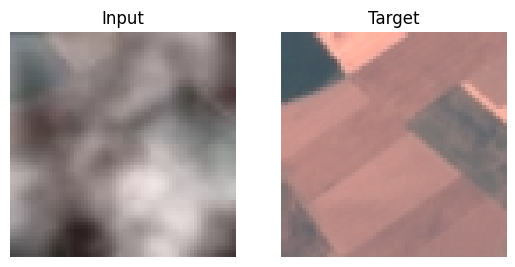

In [15]:
input_tensor, target_tensor = dataset[8766]
fig,ax = plt.subplots(1,2)
ax[0].imshow(np.asarray(input_tensor))
ax[1].imshow(np.asarray(target_tensor))
ax[0].set_title("Input")
ax[0].axis('off')
ax[1].set_title("Target")
ax[1].axis('off')
plt.show()

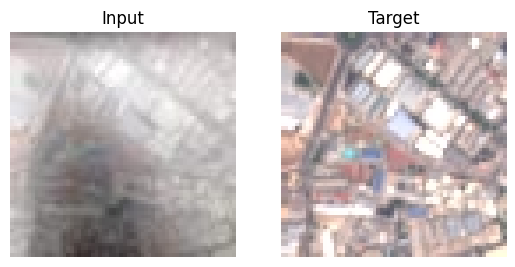

In [5]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(np.asarray(Image.open(os.path.join("data/eurosat-dataset/inputs", f'IMG_17672.jpg'))))
ax[1].imshow(np.asarray(Image.open(os.path.join("data/eurosat-dataset/targets", f'IMG_17672.jpg'))))
ax[0].set_title("Input")
ax[0].axis('off')
ax[1].set_title("Target")
ax[1].axis('off')
plt.show()